In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

import torch
from torch.autograd import Variable


Below we study a stochastic function $f_t(x)$, identical to the one demonstrated in *On the Convergence of Adam and Beyond*:

$f_t(x,y) = \begin{cases} 
    1010x + 1010y & \textrm{with probability 0.01} \\
    -10x -10y & \textrm{otherwise}
\end{cases}$

In [2]:
def f_t(x,y):
    c = np.random.choice([1010,-10], p=[0.01,0.99])
    return c*x + c*y

# Beale's function
beales  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2
# f = lambda x,y: (1010*x+1010*y)*0.01 - (10*x+10*y)*0.99 ## deterministic 2d version of function in paper


In [3]:
xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

def getMinima(x,y):
    minima = np.array([float(x),float(y)])
    minima = minima.reshape(-1,1)
    return minima

In [4]:
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = beales(x,y)

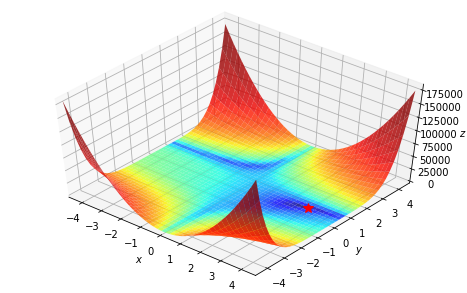

In [5]:
minima = getMinima(3,0.5)
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima, beales(*minima), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

In [6]:
x0 = np.array([3., 4.])

In [7]:
w_adam = Variable(torch.FloatTensor(x0), requires_grad=True)
adam = torch.optim.Adam([w_adam], lr = 1e-3)

In [8]:
def var_ft(x,y):
    c = np.random.choice([1010,-10], p=[0.01,0.99])
    c = np.array([float(c)])
    c = Variable(torch.FloatTensor(c))
    return (c*x + c*y)

def beales_var(var):
    x = var[0]
    y = var[1]
    
    return ((1.5 - x + x*y).pow(2) + (2.25 - x + (x*y).pow(2)).pow(2) + (2.625 - x + (x*y).pow(3)).pow(2))
#     return var_ft(x,y)

In [9]:
def get_parameterized_closure(optimizer,f,w):
    def closure(): 
        optimizer.zero_grad()
        loss = f(w)
        loss.backward()
        return loss
    return closure

In [10]:
def optimize(optim, f, w, steps, length):
    closure = get_parameterized_closure(optim,f,w)
    path = np.ndarray(shape=(steps,2),dtype=float)
    for step in range(steps):
        optim.step(closure)
        path[step][0] = w[0].data[0]
        path[step][1] = w[1].data[0]
    result = np.ndarray(shape=(length,2),dtype=float)
    idx = 0
    for n in np.linspace(0,steps-1,num=length, dtype=int):
        result[idx] = path[n]
        idx += 1
    return result

In [11]:
path = optimize(adam,beales_var,w_adam,10000, 100).T

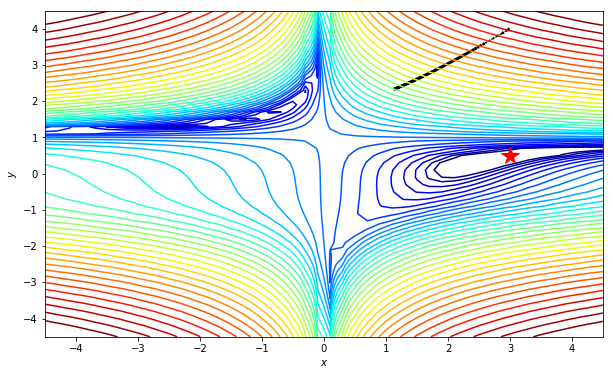

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(*minima, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=18)

line, = ax.plot([], [], 'b', label='amsgrad', lw=2)
point, = ax.plot([], [], 'bo')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.legend(loc='upper left')

In [14]:
def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

In [15]:
def animate(i):
    line.set_data(*path[::,:i])
    point.set_data(*path[::,i-1:i])
    return line, point

In [16]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=path.shape[1], interval=60, 
                               repeat_delay=5, blit=True)

In [17]:
HTML(anim.to_html5_video())

In [18]:
fig_3d = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima, beales(*minima), 'r*', markersize=10)

line_3d, = ax.plot([], [], [], 'b', label='Newton-CG', lw=2)
point_3d, = ax.plot([], [], [], 'bo')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

(-4.5, 4.5)

In [19]:
def init_3d():
    line_3d.set_data([], [])
    line_3d.set_3d_properties([])
    point_3d.set_data([], [])
    point_3d.set_3d_properties([])
    return line, point

In [20]:
def animate_3d(i):
    line_3d.set_data(path[0,:i], path[1,:i])
    line_3d.set_3d_properties(beales(*path[::,:i]))
    point_3d.set_data(path[0,i-1:i], path[1,i-1:i])
    point_3d.set_3d_properties(beales(*path[::,i-1:i]))
    return line, point

In [21]:
anim = animation.FuncAnimation(fig_3d, animate_3d, init_func=init_3d,
                               frames=path.shape[1], interval=60, 
                               repeat_delay=5, blit=True)

In [22]:
HTML(anim.to_html5_video())

In [23]:
class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, *paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

In [24]:
class TrajectoryAnimation3D(animation.FuncAnimation):
    
    def __init__(self, *paths, zpaths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths
        self.zpaths = zpaths
        
        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]

        super(TrajectoryAnimation3D, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line in self.lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return self.lines

    def animate(self, i):
        for line, path, zpath in zip(self.lines, self.paths, self.zpaths):
            line.set_data(*path[::,:i])
            line.set_3d_properties(zpath[:i])
        return self.lines

In [31]:
from amsgrad import Amsgrad

x0 = np.array([-3., 4.])


algos = {}

w_amsgrad = Variable(torch.FloatTensor(x0), requires_grad=True)
amsgrad = Amsgrad([w_amsgrad])
algos['amsgrad'] = [amsgrad,beales_var,w_amsgrad]

w_adam = Variable(torch.FloatTensor(x0), requires_grad=True)
adam = torch.optim.Adam([w_adam], lr=0.01)
algos['adam'] = [adam,beales_var,w_adam]

w_adadelta = Variable(torch.FloatTensor(x0), requires_grad=True)
adadelta = torch.optim.Adadelta([w_adadelta])
algos['adadelta'] = [adadelta,beales_var,w_adadelta]

w_adagrad = Variable(torch.FloatTensor(x0), requires_grad=True)
adagrad = torch.optim.Adagrad([w_adagrad], lr=1)
algos['adagrad'] = [adagrad,beales_var,w_adagrad]

w_rmsprop = Variable(torch.FloatTensor(x0), requires_grad=True)
rmsprop = torch.optim.RMSprop([w_rmsprop])
algos['rmsprop'] = [rmsprop,beales_var,w_rmsprop]



In [26]:
paths = []
methods = []
zpaths = []

for key in algos.keys():
    path = optimize(algos[key][0],algos[key][1],algos[key][2],50000,100).T
    paths.append(path)
    zpaths.append(beales(*path))
    methods.append(key)
    

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(*paths, labels=methods, ax=ax)

ax.legend(loc='upper left')

In [28]:
HTML(anim.to_html5_video())

In [29]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima, beales(*minima), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation3D(*paths, zpaths=zpaths, labels=methods, ax=ax)

ax.legend(loc='upper left')

In [30]:
HTML(anim.to_html5_video())